<a href="https://colab.research.google.com/github/suresh-venkate/Code_Repositories/blob/main/Deep_Learning/Computer_Vision/Projects/Car_BBOX_Detection/TF_ObjDet_E2E_Car_Dataset_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Object Detection API - Inference Only

This notebook shows how to use the TensorFlow Object Detection API for performing inference on an image using a model pre-trained on the COCO dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Copy relevant files from GitHub

In [2]:
%%capture

!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories/main/Deep_Learning/Computer_Vision/Projects/Car_BBOX_Detection/utils.py
!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories/main/Deep_Learning/Computer_Vision/Projects/Car_BBOX_Detection/Temp_Dataset.zip

!unzip Temp_Dataset.zip

# Copy model and label class mapping from Google Drive

In [3]:
# Copy model directory
!cp -r /content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/SSD_Model_Car_Dataset/detection_model .

# Copy label-class mapping pkl file
!cp /content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/SSD_Model_Car_Dataset/car_dataset_label.pkl .

# Import required libraries

In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import pytz
import time
import os
import tensorflow as tf

from PIL import Image, ImageDraw, ImageFont
from utils import draw_boxes_and_labels

%matplotlib inline

# Pascal VOC index to label mapping - Load from disk

In [5]:
# Pickle file where index to label mapping of Pascal VCO labels are stored
fname = "/content/car_dataset_label.pkl" 
with open(fname, "rb") as file:
    pascal_ind_class_dict = pickle.load(file)
    
print(f"Type of pascal_ind_label_dict is {type(pascal_ind_class_dict)}")
print()
print(f"Keys of pascal_ind_label_dict are:")
print("--------------------------------")
print(pascal_ind_class_dict.keys())
print()
print("First five elements of pascal_ind_label_dict are:")
print("-----------------------------------------------")
for ind in range(1, 6, 1):
    print(pascal_ind_class_dict[ind])

Type of pascal_ind_label_dict is <class 'dict'>

Keys of pascal_ind_label_dict are:
--------------------------------
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196])

# Download and load model

In [ ]:
%%capture

### This step is already completed and the model has been saved to disk.
### Will be re-loaded from disk for subsequent runs.

# Download and extract EfficientNet model from TensorFlow model zoo
# !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz    
# !tar -xf efficientdet_d5_coco17_tpu-32.tar.gz
# !rm efficientdet_d5_coco17_tpu-32.tar.gz

In [6]:
%%capture
# Define path where model is stored
model_path = '/content/detection_model/saved_model'
# Load model from path
model = tf.saved_model.load(model_path)

# Load input image

In [20]:
inp_img_path = "/content/Temp_Dataset/train_img/00050.jpg"
inp_img_pil = Image.open(inp_img_path) # Load image as a PIL object
inp_img_arr = np.array(inp_img_pil) # Convert PIL object to numpy array
inp_img_arr = np.expand_dims(inp_img_arr, axis = 0) # Add batch axis
print(f"Shape of inp_img_arr is {inp_img_arr.shape}")

Shape of inp_img_arr is (1, 407, 580, 3)


# Generate output from model

In [21]:
model_out = model(inp_img_arr)

In [22]:
print(f"Type of model_out is {type(model_out)}")
print()
print("Keys of model_out dict are:")
print("---------------------------")
print(model_out.keys())

Type of model_out is <class 'dict'>

Keys of model_out dict are:
---------------------------
dict_keys(['raw_detection_scores', 'detection_anchor_indices', 'detection_multiclass_scores', 'detection_classes', 'num_detections', 'detection_boxes', 'raw_detection_boxes', 'detection_scores'])


# Plot image with BBoxes

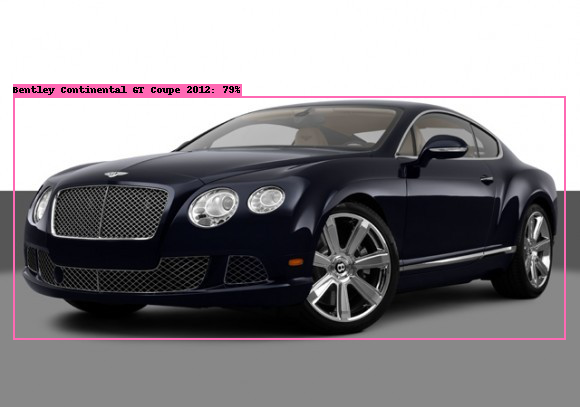

In [23]:
scores = model_out['detection_scores'][0].numpy() # Extract scores for each box
boxes = model_out['detection_boxes'][0].numpy() # Extract box co-ordinates
class_ind = model_out['detection_classes'][0].numpy().astype('int32') # Extract class indices
score_threshold = 0.4 # Boxes with scores below this threshold will be discarded
norm_coords = True # Scale box co-ordinates w.r.t image dimensions
box_thickness = 4 # Thickness to use for drawing BBOX

# Draw box and labels on image
inp_img_pil_w_bbox = draw_boxes_and_labels(inp_img_pil, scores, boxes, class_ind,\
                                           pascal_ind_class_dict, score_threshold = 0.6,\
                                           norm_coords = True, box_thickness = 2, font_size = 25)
inp_img_pil_w_bbox

# Other Images

## Function: plt_img_w_bboxes

In [ ]:
def plt_img_w_bboxes(inp_img_path, score_threshold = 0.4, norm_coords = True, box_thickness = 3,\
                     font_size = 25):

    '''
    Take an input image path, extract the image, run inference on the image to get bounding boxes
    Plot bounding boxes and labels on top of the image
    '''
    
    inp_img_pil = Image.open(inp_img_path) # Load image as a PIL object
    inp_img_arr = np.array(inp_img_pil) # Convert PIL object to numpy array
    inp_img_arr = np.expand_dims(inp_img_arr, axis = 0) # Add batch axis
    model_out = model(inp_img_arr) # Pass input image through model
    
    scores = model_out['detection_scores'][0].numpy() # Extract scores for each box
    boxes = model_out['detection_boxes'][0].numpy() # Extract box co-ordinates
    class_ind = model_out['detection_classes'][0].numpy().astype('int32') # Extract class indices
    
    # Draw box and labels on image
    inp_img_pil_w_bbox = draw_boxes_and_labels(inp_img_pil, scores, boxes, class_ind,\
                                               pascal_ind_class_dict,\
                                               score_threshold = score_threshold,\
                                               norm_coords = norm_coords,\
                                               box_thickness = box_thickness, font_size = font_size)
    
    return inp_img_pil_w_bbox

## Image 1

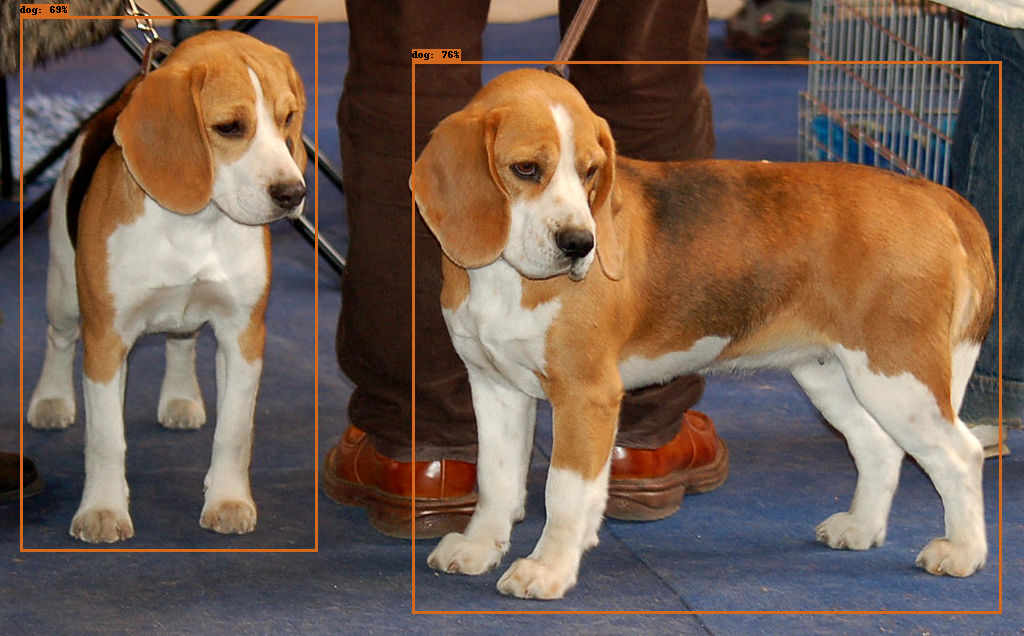

In [ ]:
inp_img_path = "./Images/image1.jpg"
plt_img_w_bboxes(inp_img_path, score_threshold = 0.6)

## Image 2

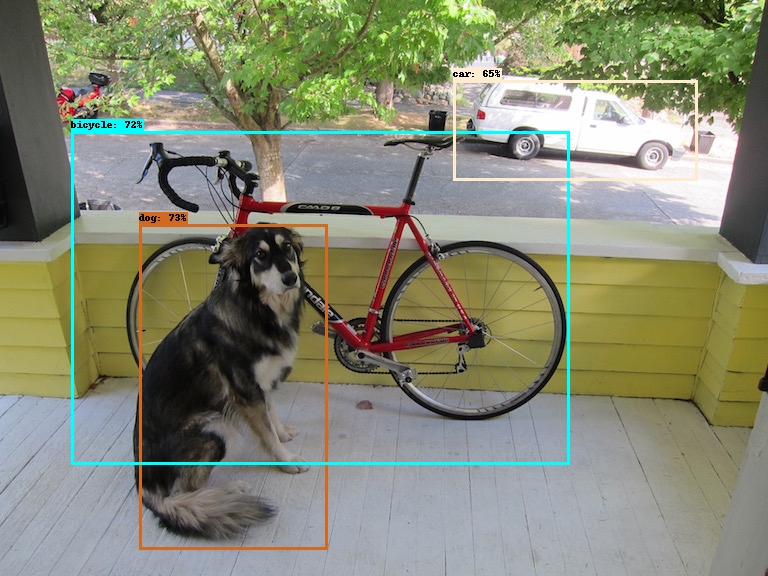

In [ ]:
inp_img_path = "./Images/image2.jpg"
plt_img_w_bboxes(inp_img_path, score_threshold = 0.6)